Uma importante medida para acompanhar o sentido da política monetária é comparar o Juro real com o Juro de equilíbrio da economia. A diferença entre os dois indicadores permite dizer se a política monetária está em sentido expansionista ou contracionista. No post de hoje mostraremos como é possível construir o Juro real e o Juro neutro utilizando o Python.

O juro real que considerei aqui é o juro real ex-ante, obtido a partir do juro do swap DI 360 deflacionado pela expectativa de inflação para os próximos 12 meses. Já o juro de equilíbrio segue uma proxy definida no Relatório de Inflação de dezembro de 2019, dada pela Selic esperada para t+3 deflacionada pela inflação esperada para t+3.



Para o cálculo, utilizamos a equação de Fisher, que nos dá a diferença entre o juro nominal e a expectativa de inflação.



In [1]:
!pip install python-bcb

In [2]:
import numpy as np
import pandas as pd

import datetime

from matplotlib import pyplot as plt
import seaborn as sns


# !pip install python-bcb

from bcb import Expectativas
from datetime import datetime
from datetime import timedelta

In [3]:
# Cria função para subtrair os dias do ano

def years_sub(days):
  sub_year_days = pd.to_datetime(datetime.today().strftime('%Y-%m-%d')) - timedelta(days = 10 * 365)
  sub_year_days = sub_year_days.strftime("%Y-%m-%d")
  return sub_year_days

# Cria função para calcular a data de referência a partir da data de observação

def reference_date(date):
  years = pd.DatetimeIndex(date).year.values + 3 # Calcula 3 anos a frente
  years = years.tolist()
  years = [str(i) for i in years]
  return years

In [4]:
# Conecta com a API das Expectativas de Mercado Anuais
em = Expectativas()
ep = em.get_endpoint('ExpectativasMercadoAnuais')


# Importa as expectativas do IPCA anuais e realiza os filtros

ipca_raw = (
  ep.query()
  .filter(ep.Indicador == "IPCA")
  .filter(ep.Data >= years_sub(10 * 365))
  .filter(ep.baseCalculo == 0)
  .select(ep.Data, ep.Mediana, ep.Minimo, ep.Maximo, ep.DataReferencia)
  .collect()
  )

# Realiza o filtro para a data de referência 3 anos a frente das obs.

ipca = ipca_raw[(
          ipca_raw
          .DataReferencia == reference_date(ipca_raw['Data'])
          )
            ]

# Renomeia as colunas

ipca = ipca.rename(columns = {'Data' : 'date',
                                  'Mediana' : 'ipca_e',
                                  'Minimo' : 'ipca_e_min',
                                  'Maximo' : 'ipca_e_max'}).drop(['DataReferencia'], axis = 1)

In [5]:
# Importa as expectativas da Selic anuais e realiza os filtros

selic_raw = (
    ep.query()
  .filter(ep.Indicador == "Selic")
  .filter(ep.Data >= years_sub(10 * 365))
  .filter(ep.baseCalculo == 0)
  .select(ep.Data, ep.Mediana, ep.Minimo, ep.Maximo, ep.DataReferencia)
  .collect()
  )

# Realiza o filtro para a data de referência 3 anos a frente das obs.

selic = selic_raw[(
    selic_raw
    .DataReferencia == reference_date(selic_raw['Data'])
    )
      ]

# Renomeia as colunas

selic = selic.rename(columns = {'Data' : 'date',
                                  'Mediana' : 'selic_e',
                                  'Minimo' : 'selic_e_min',
                                  'Maximo' : 'selic_e_max'}).drop(['DataReferencia'], axis = 1)

In [6]:
# Junta os dados em um data frame

proxy_neutro = pd.merge(left = ipca,
                        right = selic,
                        how = 'inner',
                        on = 'date')

In [7]:
# Cria a função de Fisher para calcular o juro neutro

def fisher(juros, inflacao):
  juros_neutro = ((((1 + (juros / 100)) / (1 + inflacao / 100))) -1) * 100
  return juros_neutro

In [8]:
# Realiza os cálculos
proxy_neutro = proxy_neutro.assign(neutro = lambda x : fisher(x.selic_e, x.ipca_e),
                    neutro_min = lambda x : fisher(x.selic_e_min, x.ipca_e_min),
                    neutro_max = lambda x : fisher(x.selic_e_max, x.ipca_e_max))


# Realiza a mudança para a classe datetime e period da coluna date e insere no índice do data frame

proxy_neutro = proxy_neutro.set_index(pd.to_datetime(proxy_neutro['date']).dt.to_period('D')).drop(['date'], axis = 1)
# Realiza a mudança para período mensal com base na média dos valores
proxy_neutro = proxy_neutro.resample('M').mean()

<ipython-input-8-07c6a58eda09>:11: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  proxy_neutro = proxy_neutro.resample('M').mean()


In [9]:
!pip install ipeadatapy
import ipeadatapy as ip

In [10]:
# Taxa referencial - swaps - DI pré-360 dias - média do período (IPEADATA/B3)
swaps = (
    ip.timeseries('BMF12_SWAPDI36012')
    .rename(columns = {'VALUE ((% a.a.))' : 'swaps'})[['swaps']]
)

# Muda a coluna de data para o índice

swaps = swaps.set_index(swaps.index.to_period('M'))

In [11]:
# Expectativa média do IPCA - tx. acumulada para os próximos 12 meses (Expectativas)

ifl_ep = em.get_endpoint('ExpectativasMercadoInflacao12Meses')

ipca_expec_12m_raw = (
    ifl_ep.query()
    .filter(ifl_ep.Suavizada == 'S', ifl_ep.baseCalculo == 0, ifl_ep.Indicador == 'IPCA')
    .collect()
    )

In [12]:
# Muda a classe da coluna de data para date time e period, renomeia as colunas seleciona a coluna dos valores

ipca_expec_12m = (
    ipca_expec_12m_raw
    .set_index(pd.to_datetime(ipca_expec_12m_raw['Data'])
    .dt.to_period('D'))
    .rename(columns = {'Mediana' : 'ipca_exp_12m'})
    [['ipca_exp_12m']]
                    )
# Mensaliza os dados com base na média dos valores

ipca_expec_12m = ipca_expec_12m.resample('M').mean()

<ipython-input-12-ced63d5c03f6>:12: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  ipca_expec_12m = ipca_expec_12m.resample('M').mean()


In [13]:
# Junta o df do swap e expectativas do ipca

ex_ante = ipca_expec_12m.join(swaps)

# Calcula o juro real ex-ante

ex_ante = ex_ante.assign(juro_real = lambda x: fisher(x.swaps, x.ipca_exp_12m))

In [14]:
# Junta o juro neutro e o juro real; renomeia as colunas

df_juros = (
    proxy_neutro
    .join(ex_ante)
    [['juro_real', 'neutro']]
    .rename(columns = {'juro_real' : 'Juro Real',
                                      'neutro' : 'Juro Neutro'})
      )


# Muda a coluna de data para timestamp (para gerar o gráfico)

df_juros.index = df_juros.index.to_timestamp(freq='M')

In [15]:
# Transforma de wide para long

df_juros_long = pd.melt(df_juros.reset_index(),
                        id_vars = 'date',
                        value_vars = ['Juro Real', 'Juro Neutro'],
                        var_name = 'variable',
                        value_name = 'values')

Text(1.0, -0.06, 'Fonte: analisemacro, Implementado por Juliano')

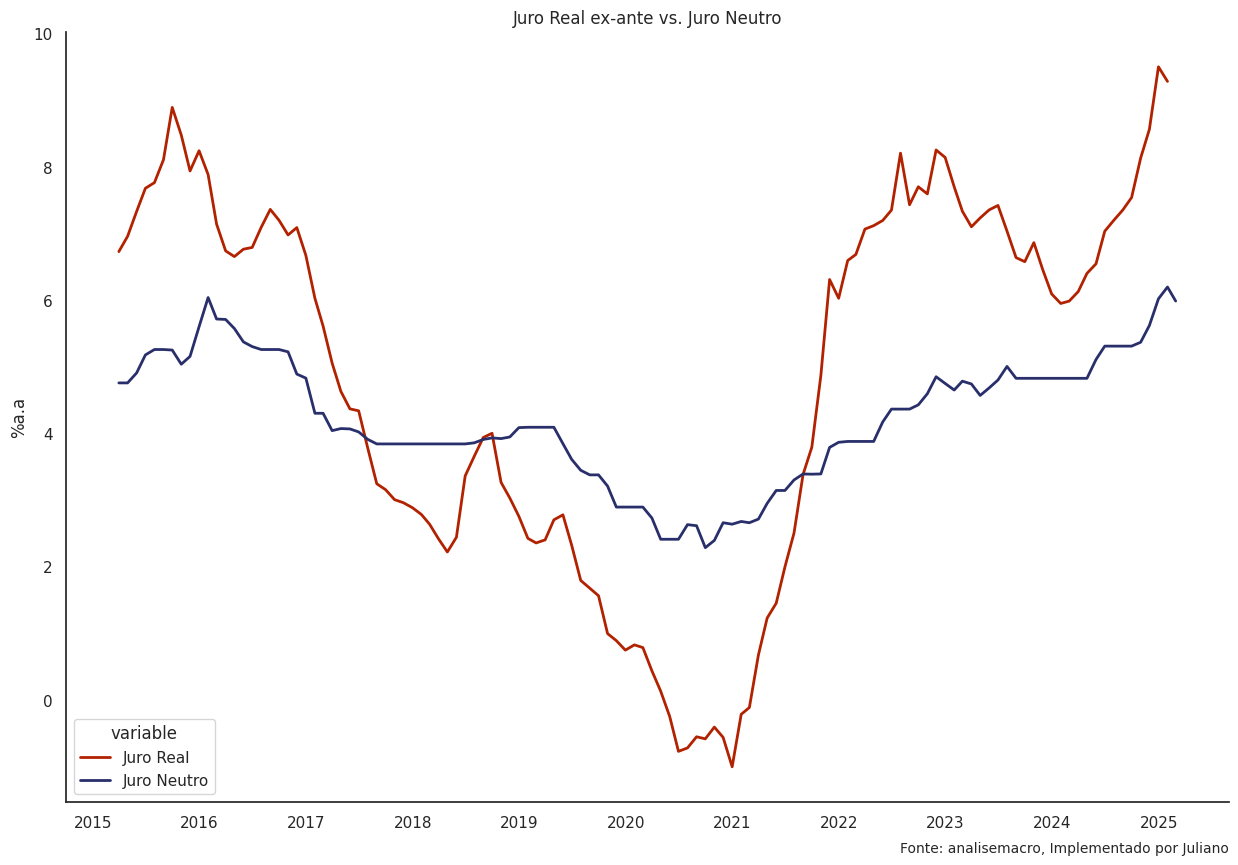

In [17]:
# Configura o tema do gráfico
theme = {'figure.figsize' : (15, 10),
         'axes.facecolor' : 'white',
         "axes.spines.right": False,
         "axes.spines.top": False}

# Cor das variáveis
colors = ['#b22200', '#282f6b']

# Adiciona as configurações
sns.set_theme(style = 'white',
              palette = colors,
              rc = theme)

# Plota
sns.lineplot(x = 'date', y = 'values',
            data = df_juros_long,
            hue = 'variable',
            linewidth = 2).set(xlabel = "",
                               ylabel = "%a.a",
                               title = "Juro Real ex-ante vs. Juro Neutro")

 # Adiciona a fonte no gráfico
plt.annotate('Fonte: analisemacro, Implementado por Juliano',
            xy = (1.0, -0.06),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)